# Config.

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

###### Data Cleaning
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

###### Models
# ~~~~~~~~~~~ Regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor


##### Measuring models
from sklearn.model_selection import cross_val_score

#from sklearn.ensemble import *
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier

This problem uses continuous data, which is the 'price' of the diamond, and consists of a range of infinite values.

The objective is to generate predictions with a low Mean Squared Error.

### Configure `PATH` for `LOCAL JUPYTER` or `Google Colab`

    """
    # Google Colab Setup
    from os.path import join
    from google.colab import drive

    ROOT = "/content/drive"
    drive.mount(ROOT)
    
    PATH = "/My Drive/data/"
    """

In [2]:
# Local Jupyter Setup
PATH='../'

# Load Training Dataset as `data_train`

In [3]:
raw_data_train = pd.read_csv(f'{PATH}INPUT/diamonds_train.csv').drop(columns='Unnamed: 0')
raw_data_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


###### `dtypes`

In [4]:
raw_data_train.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

###### `value_counts`

In [5]:
# Diamond Cut
raw_data_train.cut.value_counts()

Ideal        16090
Premium      10339
Very Good     9036
Good          3694
Fair          1186
Name: cut, dtype: int64

In [6]:
# Diamond Color
raw_data_train.color.value_counts()

G    8499
E    7351
F    7130
H    6234
D    5074
I    4023
J    2034
Name: color, dtype: int64

In [7]:
# Diamond Clarity
raw_data_train.clarity.value_counts()

SI1     9751
VS2     9178
SI2     6828
VS1     6101
VVS2    3858
VVS1    2714
IF      1362
I1       553
Name: clarity, dtype: int64

### Values to predict, a.k.a. : `label`

In [8]:
# LABEL: Diamond Price
raw_data_train.price.value_counts().head()

625    99
789    96
605    95
776    94
596    93
Name: price, dtype: int64

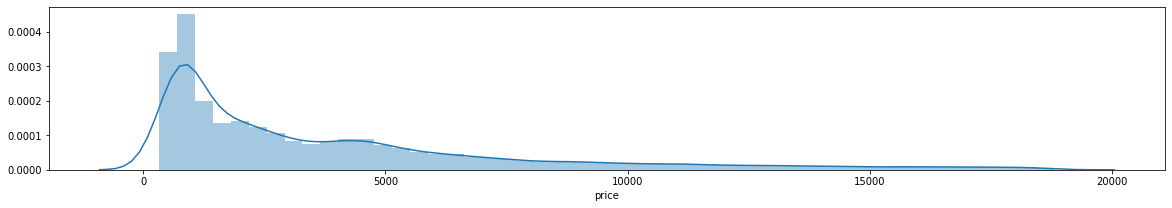

In [9]:
plt.figure(figsize=(20,3))
sns.distplot(raw_data_train.price)

## Notes from a basic investigation:

    """
    After interviewing a Diamond seller, they have recommended the use of 4 main features which are considered when calculating the price of a diamond.


    **If these features are all positive, have "balanced values", such as clarity, color, etc. the diamond will sell with a very high price.**
    """
    
    
    
    """
    The dataset contains no null values. It is composed of 8 coninuous variables and 3 categorical values.
    """
    
    """
    By looking at the distribution of the `prices`, we can see that the diamonds are more frequently under price of `5000`. Although the maximum price registered is around `20000`, giving this data to our model could actually make it less precise.
    """
    
    """
    another observation here
    """

# Data States

- Proposed:
    - `normal_price`: Do not consider very high prices
    - `four_main_features`: As described by the diamond seller

In [10]:
# We'll make a dictionary with the different states for my data inputs
# we will be updating this dictionary as we create new data_states to use with the models

data_input_states = {
    'raw':raw_data_train,
}    

### Normalization and Standarization

In [11]:
data = data_input_states['raw'].copy()
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

In [12]:
# Drop all the non-numeric fields for a first test
def to_numeric(data, columns=None):
    numeric_train_data = data.copy()
    
    for column, dtype in zip(numeric_train_data.columns, numeric_train_data.dtypes):
        if (dtype != 'float64') and (dtype != 'int64'):
            print(f"Dropping the column '{column}', with the dtype {dtype}")   
            numeric_train_data = numeric_train_data.drop(columns=column)
        
    return numeric_train_data

In [13]:
numeric_train = to_numeric(data, columns=['cut','color', 'clarity'])
data_input_states.update({'numeric_train':numeric_train})

print(numeric_train.shape)
numeric_train.head(2)

Dropping the column 'cut', with the dtype object
Dropping the column 'color', with the dtype object
Dropping the column 'clarity', with the dtype object
(40345, 7)


,carat,depth,table,x,y,z,price
0,1.21,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,64.0,56.0,4.14,4.17,2.66,532


In [14]:
# Check the dictionary of available data_input_states
data_input_states

{'raw':        carat        cut color clarity  depth  table     x     y     z  price
 0       1.21      Ideal     H     VS2   63.0   57.0  6.73  6.70  4.23   6134
 1       0.28  Very Good     D    VVS2   64.0   56.0  4.14  4.17  2.66    532
 2       0.42    Premium     F     VS1   61.2   58.0  4.86  4.82  2.96   1103
 3       0.26      Ideal     H      IF   61.1   57.0  4.16  4.12  2.53    600
 4       1.10       Good     G     SI1   63.4   57.0  6.52  6.55  4.14   4997
 ...      ...        ...   ...     ...    ...    ...   ...   ...   ...    ...
 40340   1.55    Premium     H     VS2   61.3   61.0  7.46  7.39  4.55  11708
 40341   0.36      Ideal     D     SI1   60.6   56.0  4.58  4.63  2.79    619
 40342   0.57  Very Good     I     VS2   62.2   55.0  5.33  5.34  3.32   1267
 40343   1.01  Very Good     F      IF   59.6   62.0  6.47  6.56  3.88   9965
 40344   0.54      Ideal     E     SI2   60.4   57.0  5.33  5.27  3.20   1340
 
 [40345 rows x 10 columns],
 'numeric_train':        ca

# Quick Visualization

In [15]:
data = data_input_states['numeric_train']
X = data.drop(columns='price')
y = data.price

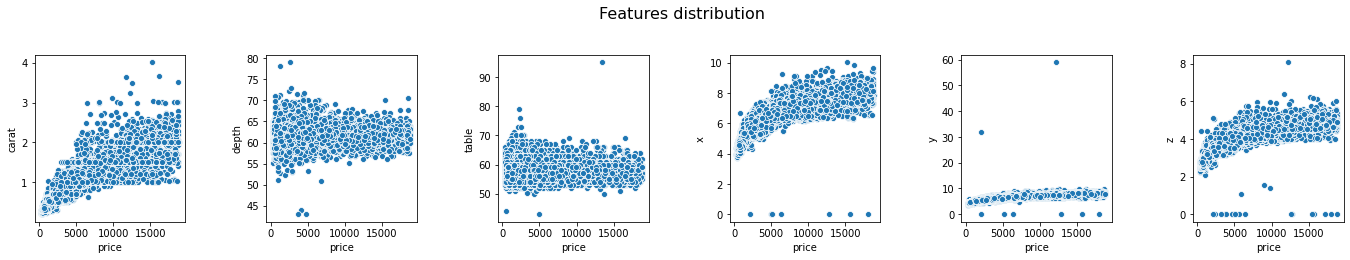

In [16]:
f,a = plt.subplots(1, len(X.columns), figsize=(20,4))
f.tight_layout(pad=5)
f.suptitle('Features distribution\n', size=16)

for i, column in enumerate(X.columns):
    sns.scatterplot(data.price, data[column],ax=a[i])

    f,a = plt.subplots(1, len(X_columns), figsize=(20,4))
    f.tight_layout(pad=5)
    f.suptitle('Features distribution\n', size=16)


    for i, column in enumerate(df.columns):
        sns.distplot(df[column],ax=a[i])
    #    a[i].set_title([i])

# Preparing variables `X` and `y`

    def prepare_train_data(dataset, drop_columns=None, label=None):

        dataset = dataset.drop(columns=drop_columns)
        X = dataset.drop(columns=label).copy()
        y = dataset[label].copy()
        return X, y

    drop_these = ['cut','color', 'clarity','Unnamed: 0'] # ONLY CONTINUOUS DATA
    # drop_these = ['Unnamed: 0']
    label = 'price'

*In the case the dataset has variables with non-numeric data (such as the color of a diamond, we have to process that data to help with training of the model)*

    # Evaluate `dtypes`

# Standardize with `Mean = 0` and   `Standard Deviation = 1`

In [17]:
pipeline = [
    StandardScaler(),
    Normalizer(),
]

tr = make_pipeline(*pipeline)

Xpr = tr.fit_transform(X)

## Visualize the data after processing it on our pipeline

In [18]:
#df = pd.DataFrame(Xpr)

    f,a = plt.subplots(1, len(X_columns), figsize=(20,4))
    f.tight_layout(pad=5)
    f.suptitle('Features distribution\n', size=16)
    for i, column in enumerate(df.columns):
        a[i].hist(df[column])
        a[i].set_title(X_columns[i])

## Train, test, split

In [19]:
print(f"Currently available data_states to use as input:")
print(data_input_states.keys())

Currently available data_states to use as input:
dict_keys(['raw', 'numeric_train'])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32276, 6) (8069, 6) (32276,) (8069,)


# Define my models

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

models = {
    'linear_regression':LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None),
    'linearSVR': LinearSVR(),
    #'NuSVR':NuSVR,
    #'SVR':SVR(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "ExtraTreeRegressor":ExtraTreeRegressor(),
    #"GaussianProcessRegressor":GaussianProcessRegressor(),
    #"GradientBoostingRegressor":GradientBoostingRegressor(),
    "HistGradientBoostingRegressor":HistGradientBoostingRegressor(),
    
}

# GRID SEARCH @@@@@@ 

In [125]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

parameters_grid = {'loss':['least_squares', 'least_absolute_deviation'],
              'learning_rate':[0.1, 0.2],
              'max_bins':[200,225,255],
              'max_iter':[50,80,100,110,120,150,180,300],
              'max_leaf_nodes':[31, 21, 41, 51,61,100],
              'scoring':['neg_mean_absolute_error', 'neg_mean_squared_error'],
              'random_state':[1, 7,21,777]}

my_model = models['HistGradientBoostingRegressor']

clf = GridSearchCV(my_model, parameters_grid)
print(clf.fit(X,y))

KeyboardInterrupt: 

In [86]:
clf.best_estimator_

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=225,
                              max_depth=None, max_iter=100, max_leaf_nodes=21,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None,
                              scoring='neg_mean_absolute_error', tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

# Predict using the LABELED data `X = data_train`

In [22]:
print("current data: X and y")
display(X_train.head(3))
display(y_train[:3])

current data: X and y


,carat,depth,table,x,y,z
11819,0.50,62.4,60.0,5.07,5.09,3.17
13097,1.29,61.9,55.0,6.95,7.01,4.32
6733,1.01,61.3,57.0,6.44,6.46,3.95


11819    1436
13097    7126
6733     5664
Name: price, dtype: int64

In [89]:
top_model = HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=225,
                              max_depth=None, max_iter=100, max_leaf_nodes=21,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None,
                              scoring='neg_mean_absolute_error', tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

scores = cross_val_score(top_model, X, y, cv=10)
print(f"   acccuracy={np.mean(scores)}")

   acccuracy=0.8846287105258582


In [88]:
# With all data
for name, model in models.items():
    print(f"({name})")
    scores = cross_val_score(model, X, y, cv=10)
    print(f"   acccuracy={np.mean(scores)}")

(linear_regression)
   acccuracy=0.8510515638823529
(linearSVR)
   acccuracy=0.7503108574620341
(DecisionTreeRegressor)
   acccuracy=0.7697865997728225
(ExtraTreeRegressor)
   acccuracy=0.7739934343467556
(HistGradientBoostingRegressor)
   acccuracy=0.8849228607781348


In [81]:
# With the dropped columns
for name, model in models.items():
    print(f"({name})")
    scores = cross_val_score(model, Xpr, y, cv=10)
    print(f"   acccuracy={np.mean(scores)}")

(linear_regression)
   acccuracy=0.7280751933694012
(linearSVR)
   acccuracy=0.5091741699436738
(DecisionTreeRegressor)
   acccuracy=0.7629146897240892
(ExtraTreeRegressor)
   acccuracy=0.763153328724145
(HistGradientBoostingRegressor)
   acccuracy=0.877228064364475


In [24]:
break

SyntaxError: 'break' outside loop (<ipython-input-24-6aaf1f276005>, line 4)

# Choose my favorite model

In [33]:
X

,carat,depth,table,x,y,z
0,1.21,63.0,57.0,6.73,6.70,4.23
1,0.28,64.0,56.0,4.14,4.17,2.66
2,0.42,61.2,58.0,4.86,4.82,2.96
3,0.26,61.1,57.0,4.16,4.12,2.53
4,1.10,63.4,57.0,6.52,6.55,4.14
...,...,...,...,...,...,...
40340,1.55,61.3,61.0,7.46,7.39,4.55
40341,0.36,60.6,56.0,4.58,4.63,2.79
40342,0.57,62.2,55.0,5.33,5.34,3.32
40343,1.01,59.6,62.0,6.47,6.56,3.88


# Predict using the UNLABELED data `X = data_test`

In [90]:
# Choose the correct columns to fit the model
def select_features(dataframe):
    data = dataframe.copy()
    data.drop(columns='price', inplace=True)
    my_features = data.columns
    return my_features
my_features = select_features(data_input_states['numeric_train'])
my_features

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')

In [91]:
data_test = pd.read_csv(f'{PATH}INPUT/diamonds_test.csv')#.drop(columns='Unnamed: 0')
data_test.head(3)

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.30,Ideal,H,SI2,60.0,56.0,4.41,4.43,2.65
1,1,0.34,Ideal,D,IF,62.1,57.0,4.52,4.46,2.79
2,2,1.57,Very Good,I,VS2,60.3,58.0,7.58,7.55,4.56


In [92]:
Xpr = tr.fit_transform(X[my_features])

In [114]:
#trained = models['HistGradientBoostingRegressor'].fit(X, y)
trained = top_model.fit(X, y)

In [115]:
my_trained_prediction = trained.predict(X_test)
my_trained_prediction == y_test.sum()

array([False, False, False, ..., False, False, False])

In [116]:
print(Xpr[0]) # Array of processed model
print(Xpr.shape)

[ 0.43419643  0.43286557 -0.10159308  0.44273234  0.41655744  0.4942142 ]
(40345, 6)


In [117]:
my_prediction = trained.predict(data_test[my_features])
pd.DataFrame(my_prediction).head()

,0
0,746.002905
1,789.574147
2,10929.365872
3,735.327770
4,9631.217017


In [118]:
df = pd.DataFrame(my_prediction)
df = df.reset_index()
df.head(2)

,index,0
0,0,746.002905
1,1,789.574147


In [119]:
df.columns = ['id', 'price']
df.head(3)

,id,price
0,0,746.002905
1,1,789.574147
2,2,10929.365872


In [120]:
df.shape

(13449, 2)

In [121]:
df.to_csv(f'{PATH}OUTPUT/my_prediction.csv', columns=['id','price'], index_label=False,index=False)

In [122]:
submission = pd.read_csv(f'{PATH}OUTPUT/my_prediction.csv')
submission.head(3)

,id,price
0,0,746.002905
1,1,789.574147
2,2,10929.365872


In [123]:
submission.shape

(13449, 2)